In [1]:
import numpy as np
from scipy.optimize import fminbound
from matplotlib import pyplot as plt
%matplotlib nbagg
plt.ion()

# LaTex setup
$\renewcommand{\vec}[1]{#1}$
$\newcommand{\mat}[1]{\vec #1}$
$\newcommand{\Trans}{^\top}$
$\newcommand{\iTrans}{^{-\top}}$

In [2]:
import os
import sys
sys.path.append('/home/simon/Desktop/workspace/jupyter_slides/python_scripts')
from nb_setup import LatexProvider

tex_tmp_folder = os.getcwd() + os.path.sep + "tex_tmp"  # path to a folder where we can store the tex garbage
preamble_location = os.getcwd() + os.path.sep + "../preamble.tex" # path to a latex preamble to load packages, etc."

lx_provider = LatexProvider(tex_tmp_folder=tex_tmp_folder, preamble_location=preamble_location)
lx_provider.clean_latex()  # can't hurt to clean the temporary folder everytime we run this notebook

def latex(code: str, uid=None):
    return lx_provider.latex(code, uid=uid)


In [3]:
# for some reason it's necessary to call this twice
%matplotlib nbagg
plt.ion()

In [5]:
def evaluate(f, x, y):
    m, n = x.shape
    X = np.vstack((x.flatten(), y.flatten()))
    z = np.zeros((m*n))
    
    for i in range(m*n):
        z[i] = f(X[:,i])
        
    z.shape = m, n
    return z
        
def draw_func(f, x, y, ax):
    """ x and y shoud be returned by np.mgrid """
    z = evaluate(f, x, y)
    ax.plot_surface(x, y, z)
   
    
def draw_level_lines(f, x, y, contours, ax):
    z = evaluate(f, x, y)
    handle = ax.imshow(z, extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(x,y,z,contours, colors='black')
    plt.colorbar(handle)
    
    
def plot_function(f, x1, y1, x2, y2, contours):
    fig = plt.figure()
    ax1 = fig.add_subplot(121, projection="3d")
    ax2 = fig.add_subplot(122)
    draw_func(f, x1, y1, ax1)
    draw_level_lines(f, x2, y2, contours, ax2) 

def make_f3(alpha, d=2, epsilon=1e-16):
    """ Log-ellispoid function """
    
    l = np.arange(0,d)
    a = np.power(alpha, l/(d-1.0))
    
    def f1(x):
        #return a@(x**2)
        return a@np.square(x)
    
    def f3(x):
        return np.log(epsilon + f1(x))
    
    def grad_f3(x):
        return 2*a*x/f1(x)

    def Hessian_f3(x):
        f = f1(x)**2
        H = np.zeros((d, d))
        for i in range(d):
            b = a.copy()
            b[i] = -b[i]
            g = epsilon + np.sum(b*x**2)
            H[i, i] = 2*a[i]*g/f
            
            for j in range(i+1,d):
                H[i, j] = H[j, i] = -4*a[i]*a[j]*x[i]*x[j]/f
        return H
    
    return f3, grad_f3, Hessian_f3

# <center>Line Search Methods</center>

## About Me <small>allow me to introduce myself</small>
<ul><li> PostDoc at KU and DTU </li>
<ul>
    <li>Biology and Machine Learning (Wouter Boomsma, KU)</li>
    <li>Deep generative models (Jes Frellsen, DTU)</li>
</ul>
</ul>

### Main Interest:  Optimization of functions of proteins

<style>
div {text-align: right;}
</style>
<table><tr><th></th>
<th>    
<img src=https://upload.wikimedia.org/wikipedia/commons/9/94/Protein_translation.gif>
</th>
<th align=left>
<ul align=left>
    <!--<li align=left>Optimization of functions of proteins</li>-->
    <li>protein = string of letters</li>
    <li>Which letters to substitute/delete/add for better $f$?</li>
    <ul>
    <li>e.g. which mutations of SARS-CoV-2's spike protein minize a vaccinations efficiency?</li>
    <li>NOT what I am working on (just an example)</li>
    </ul>
</ul></th>
</tr></table>

 * discrete optimization
  * no gradients
 * high dimensional
 * function evaluations are expensive!
  * $f(x)$ = highly paid chemists stuff expensive chemicals into expensive devices

# Line Search Methods

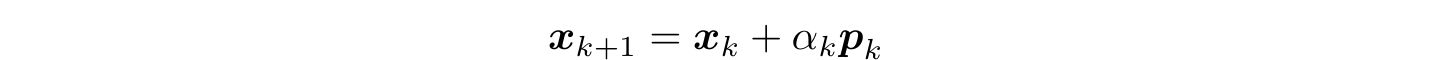

In [6]:
latex(r"$$\vec x_{k+1}=\vec x_{k}+\alpha_k \vec p_k$$")

### Contents

1. deciding $\alpha_k$
 * acceptable $\alpha_k$: Wolfe conditions
 * computing $\alpha_k$: bisection

2. deciding $\vec p_k$
 * Zoutendijk's theorem
 * steepest descent
 * Newton's method

## Finding $\alpha_k$
* assume descent direction $\vec p_k$ given, that is
$$\vec p_k\Trans \nabla f(\vec x_k)<0$$
* How far should we go? Ideally: 

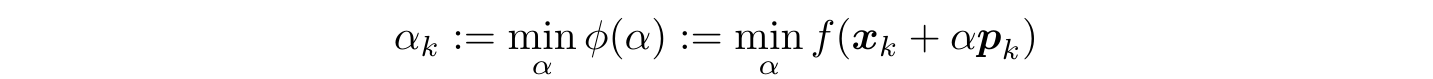

In [7]:
latex(r"""
$$\alpha_k:=\min_{\alpha} \phi(\alpha):=\min_{\alpha} f(\vec x_k + \alpha\vec p_k)$$
""")

* simpler problem: one-dimensional optimization

**trade-off for finding $\alpha_k$**
 * (substantial) improvement on function value
  * $\alpha_k >> 0$
 * use few evaluations of $\phi$ and $\phi'$
 * How to define an *acceptable* $\alpha_k$?

### Acceptable $\alpha_k$ -- The Wolfe Conditions
* demand improvement
* demand reduction in curvature
 * (since we want to get to a minimum)

In [55]:
def plot_wolfe_conditions(alphas, x0, p, f, df, c1, c2, ax=None, stage=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        if ax.get_legend() is not None:
            ax.get_legend().remove()
    def phi(alpha):
        return f(x0 + alpha * p)
    
    def cond1(alpha):
        return f(x0) + c1 * alpha * np.sum(df(x0) * p)

    def cond2(alphas):
        #c = c2 * np.sum(df(x0) * p)
        c = 0
        return np.array([np.sum(df3(x0 + a * p) * p) - c for a in alphas])

    phis = np.array([phi(alpha) for alpha in alphas])
    if stage is None or stage == 1:
        ax.plot(alphas, phis, label="$\\phi(\\alpha)$", color='black', linewidth="5")
    cond1_ = cond1(alphas) # - phis
    cond2_ = cond2(alphas)
    if stage is None or stage == 2:
        ax.plot(alphas, cond1_, color='blue', label="1st condition (RHS)")
    if stage is None or stage == 3:
        c = c2 * np.sum(df(x0) * p)
        ax.plot([alphas[0], alphas[-1]], [c, c], color='red')
        ax.text(alphas[0], c+.5, "$c_2 \\nabla f_k^\\top p_l$")
        ax.plot(alphas, cond2_, color='red', label="2nd condition (RHS)")
    fulfilled = ((cond1_ - phis) > 0) & (cond2_ > 0)
    idx_fulfilled = np.squeeze(np.where(fulfilled > 0))
    if stage is None or stage == 4:
        ypos = -5.5
        ax.plot([np.min(alphas), np.max(alphas)], [ypos, ypos], '--', color='red', label="not acceptable")
        ax.plot(alphas[idx_fulfilled], ypos * np.ones(idx_fulfilled.size), color='green', linewidth='5', label="acceptable")
    ax.legend()

**formally**

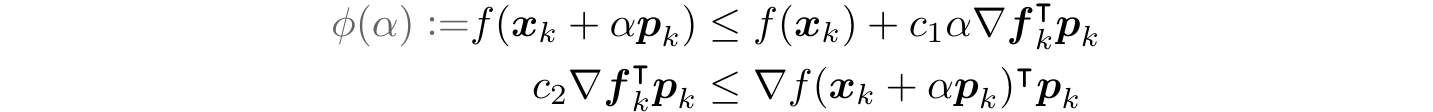

In [9]:
latex(
r"""
\begin{align*}
\textcolor{gra}{\phi(\alpha)\ce} f(\vec x_{k} + \alpha\vec p_k)&\leq f(\vec x_k) + c_1\alpha \nabla \vec f_k\Trans \vec p_k
\\ c_2\nabla \vec f_k\Trans \vec p_k&\leq \nabla f(\vec x_{k} + \alpha\vec p_k)\Trans\vec p_k
\end{align*}
"""
)

In [56]:
f3, df3, _ = make_f3(alpha=100, d=2.)
xmin, xmax = -5, 5
ymin, ymax = -5, 5
#x1, y1 = np.mgrid[xmin : xmax : 40j,  ymin : ymax : 40j]
x2, y2 = np.mgrid[xmin : xmax : 400j, ymin: ymax : 400j]
alphas = np.linspace(0, 2, 100)

In [57]:
#x0 = np.array([-4, -0.25])
x0 = np.array([-4, -1.25])
p = -df3(x0)
c1 = 4 * 1e-1
#print("c1: " + str(c1) + " (for visualization / in practice: 0.0001)")
c2 = 0.9
#print("c2: " + str(c2))

<IPython.core.display.Javascript object>


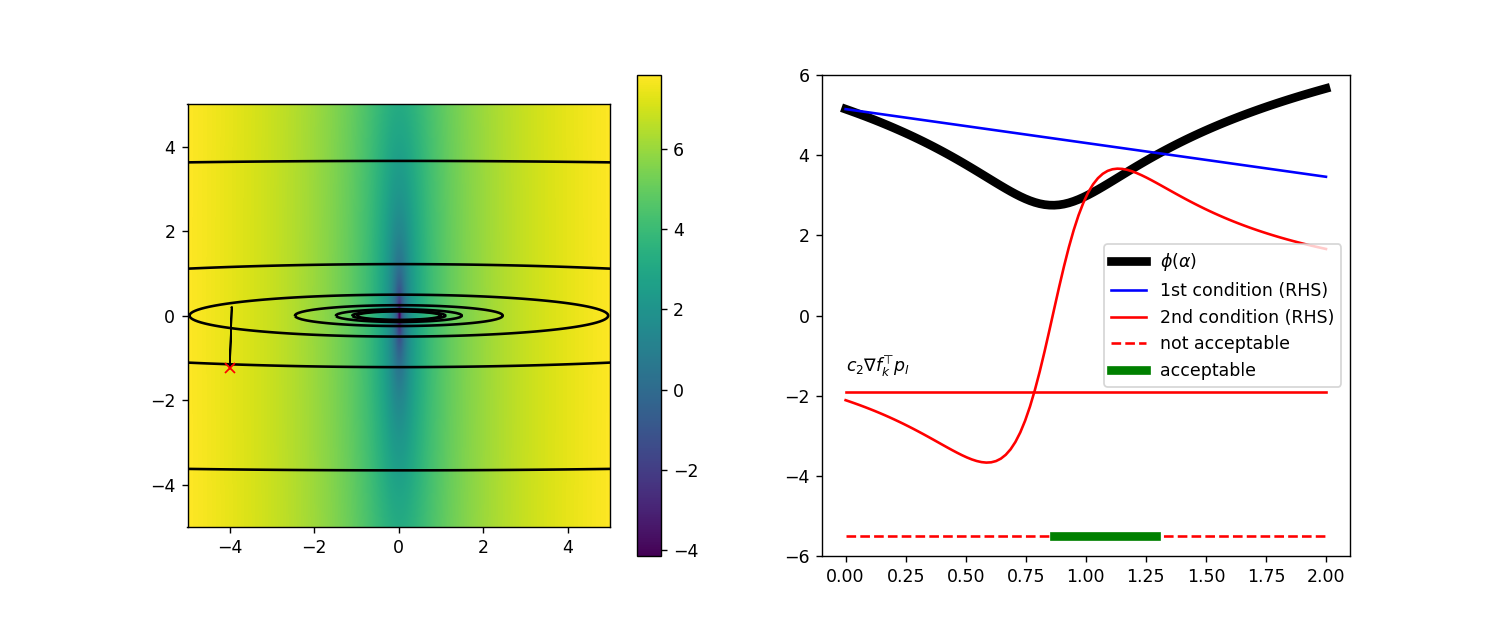

In [58]:
#plt.ioff()
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
draw_level_lines(f3, x2, y2, [i**2/5 for i in range(10)], plt.gca())
ax.plot(x0[0], x0[1], 'x', color='red')
ax.arrow(x0[0], x0[1], p[0], p[1], color='black')
#plt.savefig('tex_tmp/contour.png')
ax = fig.add_subplot(122)
ax.set_ylim([-6, 6])
plot_wc = lambda stage: plot_wolfe_conditions(alphas, x0=x0, p=p, f=f3, df=df3, c1=c1, c2=c2, ax=ax, stage=stage)
plot_wc(1)
state = [2]
def onclick(event):
    if state[0] > 4:
        state[0] = 1
        ax.clear()
        ax.set_ylim([-6, 6])
    plot_wc(state[0])
    state[0] = state[0] + 1

fig.canvas.mpl_connect('button_press_event', onclick);

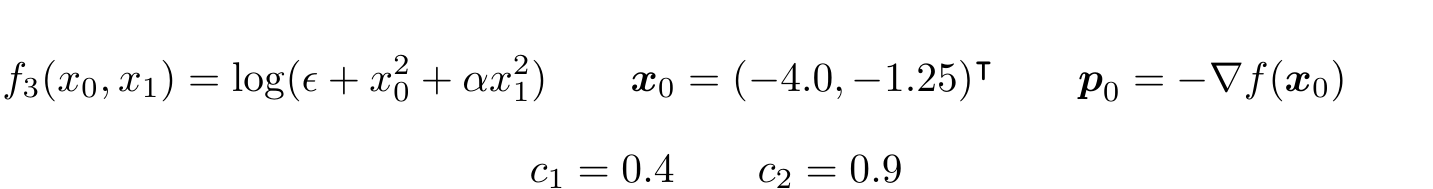

In [13]:
latex(r"""
$$
f_3(x_0, x_1)=\log(\epsilon+x_0^2+\alpha x_1^2) \qquad
\vec x_0 = (%s, %s)\Trans \qquad
\vec p_0 = -\nabla f(\vec x_0) \qquad
$$
$$
c_1=%s \qquad c_2 = %s$$
""" % (str(x0[0]), str(x0[1]), str(c1), str(c2)))

**noteworthy** 
 * scaling or adding a constant to $f$ has no effect
 * in practice, $c_1$ and $c_2$ are fixed

**strong Wolfe conditions**
 * enforce $\alpha$ to be closer to minima (compared to Wolfe conditions)

> If $f$ is continuously differentiable and bounded from below, the (strong) Wolfe conditions are **satisfiable**. (Lemma 3.1)

## Computing $\alpha$
* backtracking
* interpolation methods
* not necessarily satisfying the Wolfe conditions
* Algorithm 3.5 does

## A bisection method for the weak Wolfe conditions
* not in the book
* https://sites.math.washington.edu/~burke/crs/408/notes/nlp/line.pdf

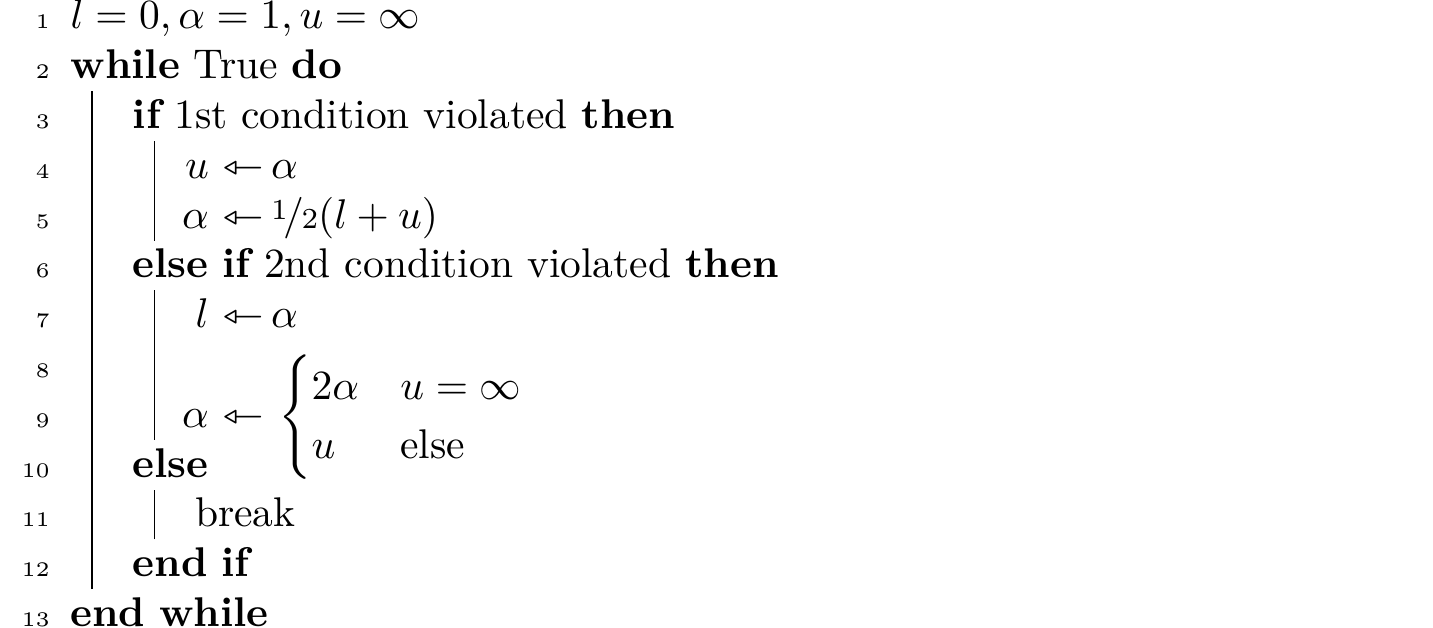

In [18]:
latex(r"""
\begin{algorithmic}[1] 
    \LState $l= 0, \alpha=1, u=\infty$
    \While{True}
    \If{\raisebox{0pt}[-1pt][-1pt]{1st condition violated}}
    \LState \algalign{~}{u}{\alpha}
    \LState \algalign{~}{\alpha}{\nicefrac{1}{2}(l+u)}
    \ElsIf{2nd condition violated}
    \LState \algalign{~}{l}{\alpha}
    \LState
    \LState \algalign{~}{\alpha}{\begin{cases}2\alpha & u = \infty\\ u & \text{else}\end{cases}}
    \Else
    \LState break
    \EndIf  
    \EndWhile
\end{algorithmic}

""")

<IPython.core.display.Javascript object>


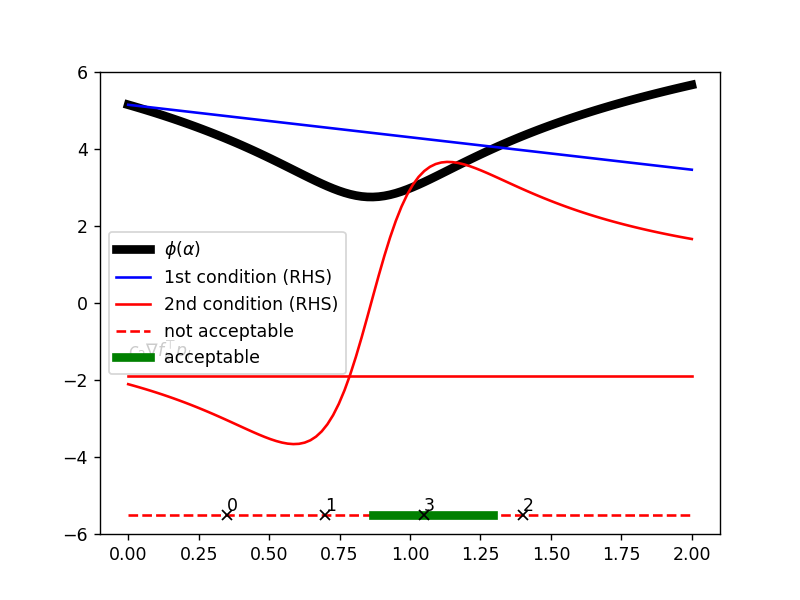

In [33]:
def cond1(alpha, c1, f=f3, df=df3):
    return f(x0) + c1 * alpha * np.sum(df(x0) * p)

def cond2(alphas, c2, df=df3):
    c = c2 * np.sum(df(x0) * p)
    return np.array([np.sum(df3(x0 + a * p) * p) - c for a in alphas])

def phi(alpha, f=f3):
    return f(x0 + alpha * p)

def bisec():
    als = []
    l, a, u = 0, .35, np.infty
    while True:
        als.append(a)
        if cond1(a, c1) < phi(a):
            u = a
            a = (u + l) / 2
        elif cond2([a], c2) < 0:
            l = a
            if u < np.infty:
                a = u
            else:
                a = 2 * a
        else:
            break
    return als

bisecs = bisec()
state = [0]

fig = plt.figure()
ax = fig.add_subplot(111)
plot_wolfe_conditions(alphas, x0=x0, p=p, f=f3, df=df3, c1=c1, c2=c2, ax=ax)
ax.set_ylim([-6, 6])
def onclick(event):
    if state[0] >= len(bisecs):
        state[0] = 0
        ax.clear()
        plot_wolfe_conditions(alphas, x0=x0, p=p, f=f3, df=df3, c1=c1, c2=c2, ax=ax)
        ax.set_ylim([-6, 6])
    i = state[0]
    b = bisecs[i]
    ypos = -5.5
    plt.plot(b, ypos, 'x', color='black')
    plt.text(b, ypos + 0.1, str(i))
    state[0] = state[0] + 1

fig.canvas.mpl_connect('button_press_event', onclick);

* terminates if $f$ is bounded from below

## The Search Direction

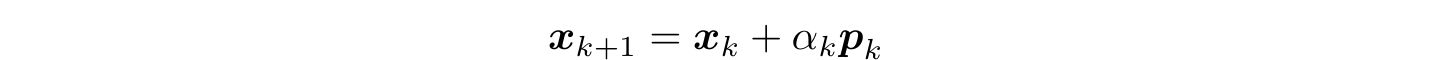

In [20]:
latex(r"$$\vec x_{k+1}=\vec x_{k}+\alpha_k \vec p_k$$")

### Zoutendiijk's theorem 

**if (conditions on the algorithm)**
 * $\vec p_k$ is a descent direction, which means $\nabla f(\vec x_k)\Trans \vec p_k<0$
 * $\alpha_k$ satisfies the Wolfe conditions

**and if (conditions on the function)**
 * bounded from below
 * continuously differentiable (for points with lower function value than $f(x_0)$)
 * Lipschitz continuous gradients

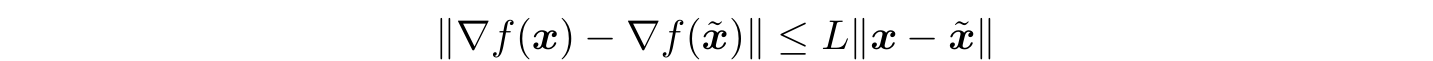

In [21]:
latex(r"""
$$\norm{\nabla f(\vec x)-\nabla f(\tilde{\vec x})}\leq L\norm{\vec x -\tilde{\vec x}}$$
""")

**then**

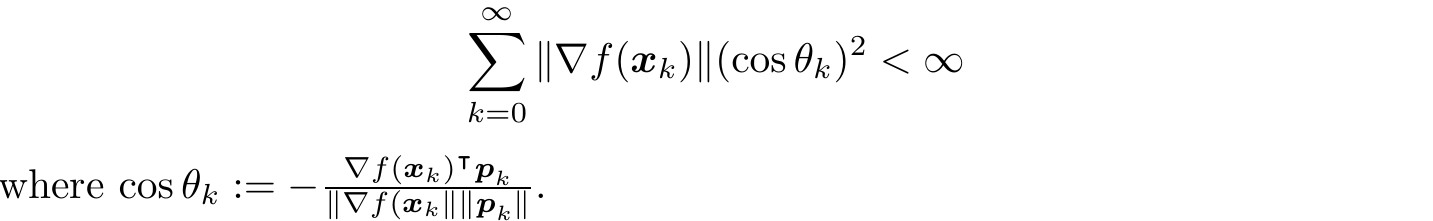

In [22]:
latex(
r"""
%%Under certain conditions (following below):
%%$$\sum_{k=0}^\infty \left(\frac{\nabla f(\vec x_k)\Trans\vec p_k}{\norm{\vec p_k}}\right)^2<\infty$$
%%or, equivalently
$$\sum_{k=0}^\infty \norm{\nabla f(\vec x_k)}(\cos \theta_k)^2<\infty$$
where $\cos \theta_k:=-\frac{\nabla f(\vec x_k)\Trans\vec p_k}{\norm{\nabla f(\vec x_k}\norm{\vec p_k}}$.
"""
)

> If the angle between search directions $\vec p_k$ and negative gradients $-\nabla f(\vec x_k)$ are less than $90^\circ$, then the gradients will approach $0$ in the limit.

### Proof Sketch

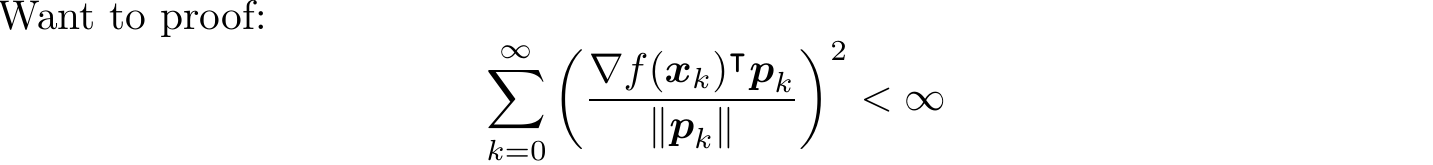

In [23]:
latex(
r"""
Want to proof:
$$\sum_{k=0}^\infty \left(\frac{\nabla f(\vec x_k)\Trans\vec p_k}{\norm{\vec p_k}}\right)^2<\infty$$
"""
)

**idea: show**

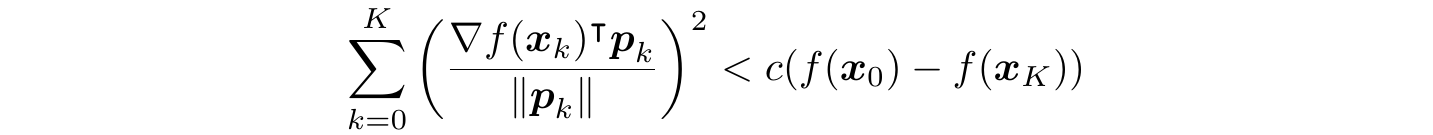

In [24]:
latex(
r"""
$$\sum_{k=0}^K \left(\frac{\nabla f(\vec x_k)\Trans\vec p_k}{\norm{\vec p_k}}\right)^2<c (f(\vec x_0)-f(\vec x_K)})$$
"""
)

then, because $f$ is bounded from below, this sum must be finite

**1st step**: positive lower bound on $\alpha_k$

From the second Wolfe conditions

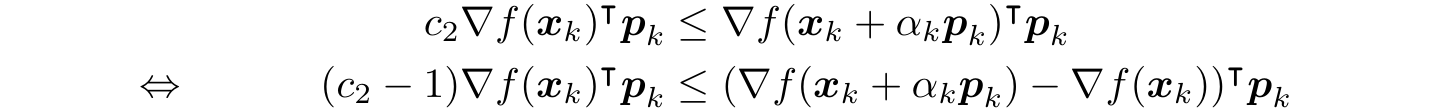

In [25]:
latex(
r"""
\begin{align*}
&& c_2 \nabla f(\vec x_k)\Trans \vec p_k&\leq \nabla f(\vec x_k+\alpha_k\vec p_k)\Trans\vec p_k
\\\Leftrightarrow && (c_2 -1) \nabla f(\vec x_k)\Trans \vec p_k&\leq (\nabla f(\vec x_k+\alpha_k\vec p_k)-\nabla f(\vec x_k))\Trans\vec p_k
\end{align*}
"""
)

and the Lipschitz assumption (with Cauchy-Schwarz):

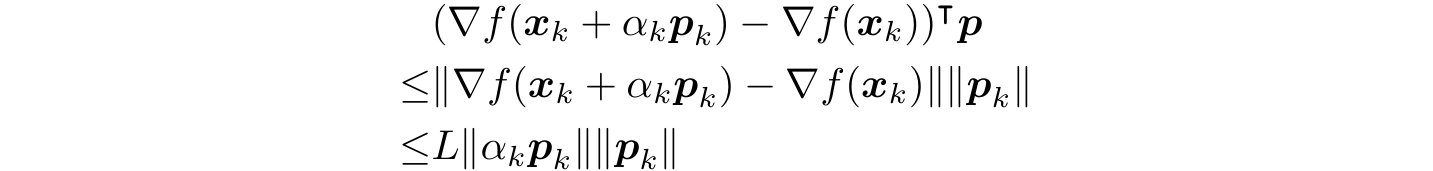

In [26]:
latex(
r"""
\begin{align*}
&(\nabla f(\vec x_k+\alpha_k\vec p_k)-\nabla f(\vec x_k))\Trans \vec p 
\\\leq &\norm{\nabla f(\vec x_k+\alpha_k\vec p_k)-\nabla f(\vec x_k)}\norm{\vec p_k}
\\\leq &L \norm{\alpha_k \vec p_k}\norm{\vec p_k}
\end{align*}
"""
)

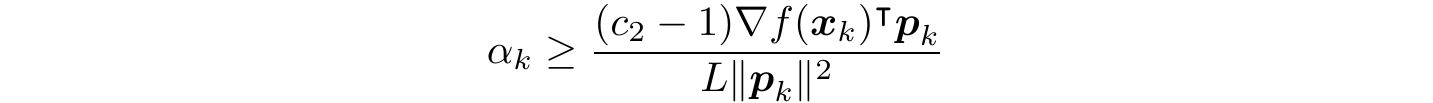

In [27]:
latex(
r"""
$$\alpha_k\geq \frac{(c_2-1)\nabla f(\vec x_k)\Trans \vec p_k}{L\norm{\vec p_k}^2}
"""
)

**2nd step:** plug into first Wolfe condition (sufficient decrease)

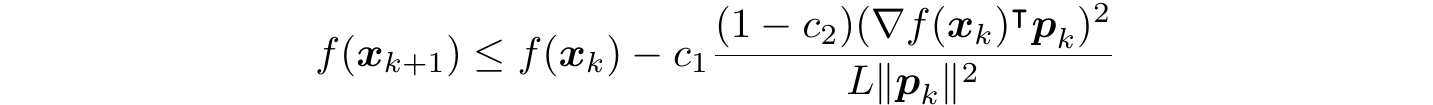

In [28]:
latex(
r"""
\begin{align*}
&f(\vec x_{k+1})\leq f(\vec x_k)-c_1\frac{(1-c_2)(\nabla f(\vec x_k)\Trans \vec p_k)^2}{L\norm{\vec p_k}^2}
\end{align*}
"""
)

recursive application gives

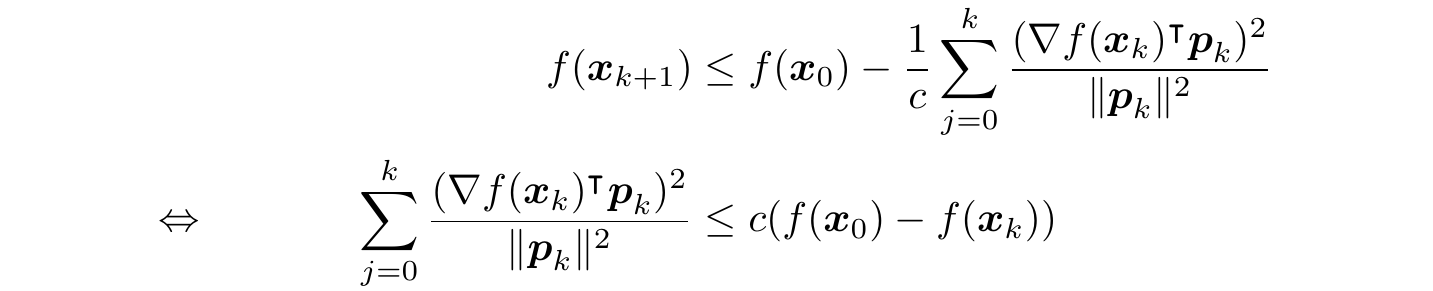

In [29]:
latex(
r"""
\begin{align*}
&&f(\vec x_{k+1})&\leq f(\vec x_{0})-\frac{1}{c}\sum_{j=0}^k \frac{(\nabla f(\vec x_k)\Trans \vec p_k)^2}{\norm{\vec p_k}^2}
\\\Leftrightarrow &&\sum_{j=0}^k \frac{(\nabla f(\vec x_k)\Trans \vec p_k)^2}{\norm{\vec p_k}^2} 
&\leq c(f(\vec x_0)-f(\vec x_k))
\end{align*}
"""
)

* similar results for Goldstein and strong Wolfe conditions
* if $f$ is **not** bounded from below, it's hard to expect that optimization should stop

### Steepest descent
How about $\vec p_k:=-\nabla f(\vec x_k)$?

Might take a while, even on simple problems.

In [60]:
def plot_quadratic(L, b):
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5
    x1, y1 = np.mgrid[xmin : xmax : 40j,  ymin : ymax : 40j]
    x2, y2 = np.mgrid[xmin : xmax : 400j, ymin: ymax : 400j]
    fig = plt.figure()
    ax2 = fig.add_subplot(111)
    
    contours = [f(i * np.ones(2) + newton(x0, df(x0), ddf(x0))) for i in range(5)]
    draw_level_lines(f, x2, y2, contours, ax2)
    return fig, ax2

def plot_step(method, x0, color, label=None):
    g, H = df(x0), ddf(x0)
    x1 = method(x0, g, H)
    epsilon = 1
    ax.plot([x0[0], x1[0]], [x0[1], x1[1]], color=color, label=label)
    return x1

In [61]:
L = np.array([[1, 0.0], [0.5, 1]])
b = np.ones(2)
b[0] = -1

def make_quadratic(L, b):
    Q = L.T.dot(L)
    def f(x):
        return np.sum(np.square(L.dot(x)), axis=0) / 2 - b.T.dot(x)
    def df(x):
        return Q.dot(x) - b
    def ddf(x):
        return Q
    return f, df, ddf
f, df, ddf = make_quadratic(L, b)

In [62]:
def steepest_descent(x, g, H):
    alpha = g.T.dot(g) / g.T.dot(H).dot(g)
    return x - alpha * g

def newton(x, g, H):
    return x - np.linalg.solve(H, g)

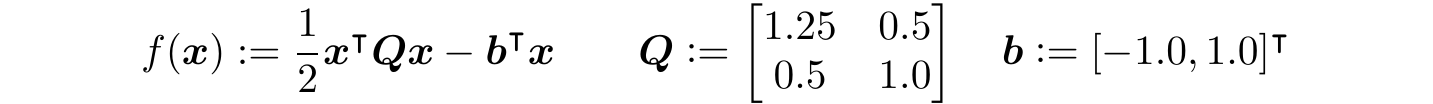

In [39]:
Q = L.T.dot(L)
latex(r"""
$$f(\vec x):=\frac{1}{2}\vec x\Trans \mat Q\vec x-\vec b\Trans \vec x
\qquad \mat Q\ce\begin{bmatrix}
%s & %s\\
%s & %s
\end{bmatrix}\quad \vec b\ce [%s, %s]\Trans
$$""" % (str(Q[0, 0]), str(Q[0, 1]), str(Q[1, 0]), str(Q[1, 1]), str(b[0]), str(b[1]))
)

using optimal(!) $\alpha_k$:

<IPython.core.display.Javascript object>


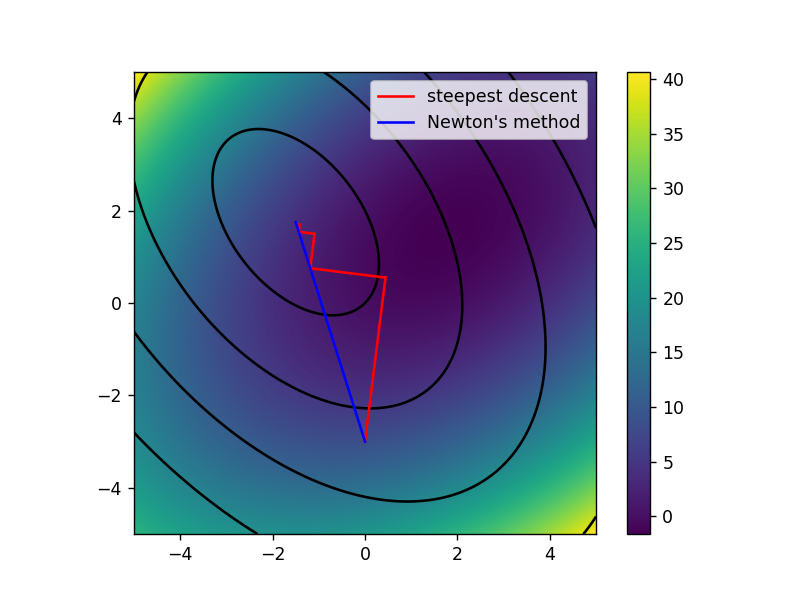

In [63]:
x0 = np.array([0, -3])
evals = 5
    
fig, ax = plot_quadratic(L=L, b=b)
    
x_sd = x0.copy()
x_n = x0.copy()
sd_label = "steepest descent"
newton_label = "Newton's method"

X_sd = [x_sd]
    
state[0] = 0
def onclick(event):
    if state[0] >= evals:
        if state[0] == evals:
            plot_step(newton, x_n, 'blue', label=newton_label)
            ax.legend()
            state[0] = state[0] + 1
        return
    if state[0] == 0:
        X_sd[0] = plot_step(steepest_descent, X_sd[0], 'red', label=sd_label)
        ax.legend()
    else:
        X_sd[0] = plot_step(steepest_descent, X_sd[0], 'red', label=None)
    state[0] = state[0] + 1

fig.canvas.mpl_connect('button_press_event', onclick);

### Newton's method
* assumes function is a quadratic
 * jumps to location of minimum
 * hence, step length: typically $\alpha_k=1$

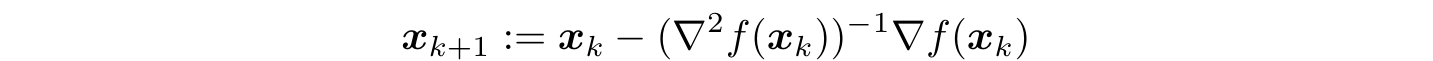

In [50]:
latex(
r"""
$$\vec x_{k+1}:=\vec x_k-(\nabla^2 f(\vec x_k))^{-1}\nabla f(\vec x_k)$$
"""
)

* if the Hessian is s.p.d., Zoutendijks theorem applies

> If the initial guess is sufficiently close to a solution and $f$ is well-behaved, then
> the iterates converge **quadratically to the solution**.

**possible issues**
* Newton direction can be NON-descending if the Hessian is not s.p.d.
 * Zoutendijk's theorem no longer applies
* Newton's method problematic if 
 * the number of parameters is large
 * computing second derivatives is expensive


## Outlook: Quasi-Newton methods
 * steepest-descent and Newton's method are at extreme ends

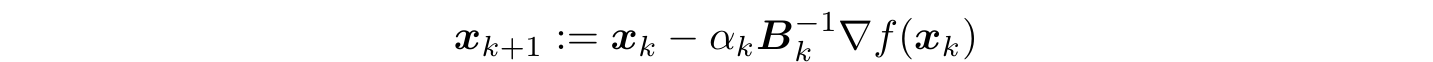

In [51]:
latex(
r"""
$$\vec x_{k+1}:=\vec x_k-\alpha_k\mat B_k^{-1}\nabla f(\vec x_k)$$
"""
)

>If $\mat B_k$ is a good approximation to the Hessian eventually, that is

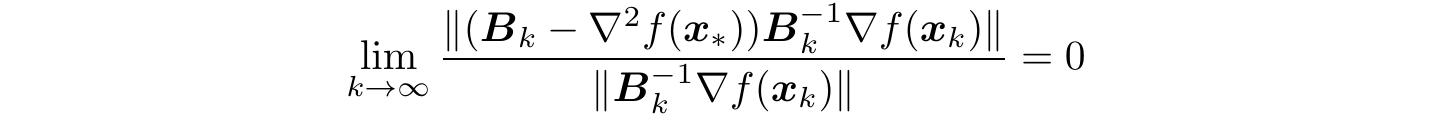

In [52]:
latex(
r"""
$$\lim_{k\rightarrow\infty} \frac{\norm{(\mat B_k-\nabla^2 f(\vec x_*))\mat B_k^{-1}\nabla f(\vec x_k)}}{\norm{\mat B_k^{-1}\nabla f(\vec x_k)}}=0$$
"""
)

> then the method will start to converge superlinearly. (Theorem 3.6)